In [1]:
from datetime import datetime, timedelta
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aaamo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
COMPANY_CODE = "UAL"

# Real Time Data Collection

In [6]:
# collecting data from yahoo finance
import yfinance as yf
today = datetime.today()
today = today.strftime("%Y-%m-%d")

start = datetime.now() - timedelta(days=100)
start = start.strftime("%Y-%m-%d")

print("Start date:", start)
print("End date:", today)

aapl = yf.Ticker(COMPANY_CODE)
stock_data = aapl.history(start=start, end=today)
stock_data

Start date: 2022-08-21
End date: 2022-11-29


In [ ]:
# collecting twitter data
import tweepy
import json

with open("twitter_api_secrets.json", "r") as f:
    api_secrets = json.load(f)
    api_key = api_secrets["api_key"]
    api_key_secret = api_secrets["api_key_secret"]
    access_token = api_secrets["access_token"]
    access_token_secret = api_secrets["access_token_secret"]

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Collecting stock data from yahoo finance

In [4]:
# collecting stock data from 2007-01-01 to 2016-12-31
import yfinance as yf
aapl = yf.Ticker(COMPANY_CODE)
stock_data = aapl.history(start="2007-01-01", end="2016-12-31")
stock_data.to_csv(f"{COMPANY_CODE}_Stock_Data.csv")
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03 00:00:00-05:00,41.894420,44.120062,41.847663,43.353245,4023900,0.0,0
2007-01-04 00:00:00-05:00,43.025942,44.653092,42.558370,44.279034,2907300,0.0,0
2007-01-05 00:00:00-05:00,43.502865,44.279032,42.857617,43.530918,2385400,0.0,0
2007-01-08 00:00:00-05:00,42.520967,44.615686,41.613877,43.764706,4700800,0.0,0
2007-01-09 00:00:00-05:00,45.045851,45.073908,43.437407,43.802113,4450000,0.0,0
...,...,...,...,...,...,...,...
2016-12-23 00:00:00-05:00,74.400002,74.830002,74.129997,74.790001,1623400,0.0,0
2016-12-27 00:00:00-05:00,74.779999,75.220001,74.500000,74.669998,1092400,0.0,0
2016-12-28 00:00:00-05:00,75.000000,75.180000,73.349998,73.529999,1946800,0.0,0


# Data Preprocessing

In [5]:
# loading stock data
stock_data = pd.read_csv(f"{COMPANY_CODE}_Stock_Data.csv")
stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2007-01-03 00:00:00-05:00,41.894420,44.120062,41.847663,43.353245,4023900,0.0,0
1,2007-01-04 00:00:00-05:00,43.025942,44.653092,42.558370,44.279034,2907300,0.0,0
2,2007-01-05 00:00:00-05:00,43.502865,44.279032,42.857617,43.530918,2385400,0.0,0
3,2007-01-08 00:00:00-05:00,42.520967,44.615686,41.613877,43.764706,4700800,0.0,0
4,2007-01-09 00:00:00-05:00,45.045851,45.073908,43.437407,43.802113,4450000,0.0,0
...,...,...,...,...,...,...,...,...
2513,2016-12-23 00:00:00-05:00,74.400002,74.830002,74.129997,74.790001,1623400,0.0,0
2514,2016-12-27 00:00:00-05:00,74.779999,75.220001,74.500000,74.669998,1092400,0.0,0
2515,2016-12-28 00:00:00-05:00,75.000000,75.180000,73.349998,73.529999,1946800,0.0,0
2516,2016-12-29 00:00:00-05:00,73.529999,74.190002,72.930000,73.279999,1272400,0.0,0


In [6]:
# setting date as index
stock_data['Date'] = stock_data['Date'].apply(lambda x: x[:10])
stock_data.index = stock_data['Date']
stock_data = stock_data.drop(['Date'], axis=1)
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03,41.894420,44.120062,41.847663,43.353245,4023900,0.0,0
2007-01-04,43.025942,44.653092,42.558370,44.279034,2907300,0.0,0
2007-01-05,43.502865,44.279032,42.857617,43.530918,2385400,0.0,0
2007-01-08,42.520967,44.615686,41.613877,43.764706,4700800,0.0,0
2007-01-09,45.045851,45.073908,43.437407,43.802113,4450000,0.0,0
...,...,...,...,...,...,...,...
2016-12-23,74.400002,74.830002,74.129997,74.790001,1623400,0.0,0
2016-12-27,74.779999,75.220001,74.500000,74.669998,1092400,0.0,0
2016-12-28,75.000000,75.180000,73.349998,73.529999,1946800,0.0,0


In [7]:
# loading twitter data
twitter_data = pd.read_csv("Twitter_Dataset.csv")
twitter_data

,Date,Tweets
0,2007-01-01,. What Sticks from '06. Somalia Orders Islamis...
1,2007-01-02,. Heart Health: Vitamin Does Not Prevent Death...
2,2007-01-03,. Google Answer to Filling Jobs Is an Algorith...
3,2007-01-04,. Helping Make the Shift From Combat to Commer...
4,2007-01-05,. Rise in Ethanol Raises Concerns About Corn a...
...,...,...
3648,2016-12-27,. Should the U.S. Embassy Be Moved From Tel Av...
3649,2016-12-28,. When Finding the Right Lawyer Seems Daunting...
3650,2016-12-29,. Does Empathy Guide or Hinder Moral Action?. ...
3651,2016-12-30,. Shielding Seized Assets From Corruption’s Cl...


In [8]:
# Removing special characters
temp_twitter_data = pd.DataFrame(columns=['Date','Tweets'])
index=0
for index, row in twitter_data.iterrows():
    stre=row["Tweets"]
    my_new_string = re.sub('[^ a-zA-Z0-9]', '', stre)
    temp_df = pd.DataFrame([[twitter_data["Date"].iloc[index], my_new_string]], columns = ['Date','Tweets'])
    temp_twitter_data = pd.concat([temp_twitter_data, temp_df], axis = 0).reset_index(drop = True)
twitter_data = temp_twitter_data.copy()
twitter_data

,Date,Tweets
0,2007-01-01,What Sticks from 06 Somalia Orders Islamists ...
1,2007-01-02,Heart Health Vitamin Does Not Prevent Death b...
2,2007-01-03,Google Answer to Filling Jobs Is an Algorithm...
3,2007-01-04,Helping Make the Shift From Combat to Commerc...
4,2007-01-05,Rise in Ethanol Raises Concerns About Corn as...
...,...,...
3648,2016-12-27,Should the US Embassy Be Moved From Tel Aviv ...
3649,2016-12-28,When Finding the Right Lawyer Seems Daunting ...
3650,2016-12-29,Does Empathy Guide or Hinder Moral Action Chi...
3651,2016-12-30,Shielding Seized Assets From Corruptions Clut...


In [9]:
# setting date as index
twitter_data.set_index(twitter_data['Date'], inplace=True)
twitter_data.drop(['Date'], axis=1, inplace=True)
twitter_data

,Tweets
Date,
2007-01-01,What Sticks from 06 Somalia Orders Islamists ...
2007-01-02,Heart Health Vitamin Does Not Prevent Death b...
2007-01-03,Google Answer to Filling Jobs Is an Algorithm...
2007-01-04,Helping Make the Shift From Combat to Commerc...
2007-01-05,Rise in Ethanol Raises Concerns About Corn as...
...,...
2016-12-27,Should the US Embassy Be Moved From Tel Aviv ...
2016-12-28,When Finding the Right Lawyer Seems Daunting ...
2016-12-29,Does Empathy Guide or Hinder Moral Action Chi...


In [10]:
# sentiment analysis of tweets
Compound = []
Positive = []
Negative = []
Neutral = []

sentiment_i_a = SentimentIntensityAnalyzer()
for indexx, row in twitter_data.T.items():
    try:
        sentence_i = unicodedata.normalize('NFKD', twitter_data.loc[indexx, 'Tweets'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        Compound.append(sentence_sentiment['compound'])
        Negative.append(sentence_sentiment['neg'])
        Neutral.append(sentence_sentiment['neu'])
        Positive.append(sentence_sentiment['compound'])
    except TypeError:
        print (temp_twitter_data.loc[indexx, 'Tweets'])
        print (indexx)

twitter_data['Compound'] = Compound
twitter_data['Positive'] = Positive
twitter_data['Negative'] = Negative
twitter_data['Neutral'] = Neutral
twitter_data

,Tweets,Compound,Positive,Negative,Neutral
Date,,,,,
2007-01-01,What Sticks from 06 Somalia Orders Islamists ...,-0.9814,-0.9814,0.159,0.749
2007-01-02,Heart Health Vitamin Does Not Prevent Death b...,-0.9258,-0.9258,0.121,0.781
2007-01-03,Google Answer to Filling Jobs Is an Algorithm...,-0.9992,-0.9992,0.198,0.730
2007-01-04,Helping Make the Shift From Combat to Commerc...,-0.9982,-0.9982,0.130,0.807
2007-01-05,Rise in Ethanol Raises Concerns About Corn as...,-0.9898,-0.9898,0.125,0.793
...,...,...,...,...,...
2016-12-27,Should the US Embassy Be Moved From Tel Aviv ...,-0.9877,-0.9877,0.177,0.715
2016-12-28,When Finding the Right Lawyer Seems Daunting ...,-0.9822,-0.9822,0.175,0.703
2016-12-29,Does Empathy Guide or Hinder Moral Action Chi...,-0.9599,-0.9599,0.137,0.753


% of positive tweets: 45.03148097454147
% of negative tweets: 54.66739666027922


[]

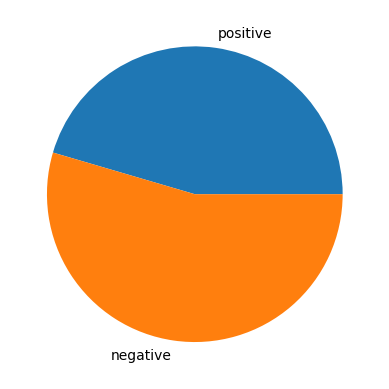

In [12]:
# visualizing sentiment analysis
posi=0
nega=0
for i in range (0,len(twitter_data)):
    get_val=twitter_data.Compound[i]
    if(float(get_val)<(-0.99)):
        nega=nega+1
    if(float(get_val>(-0.99))):
        posi=posi+1
posper=(posi/(len(twitter_data)))*100
negper=(nega/(len(twitter_data)))*100
print("% of positive tweets:",posper)
print("% of negative tweets:",negper)
arr=np.asarray([posper,negper], dtype=int)
plt.pie(arr,labels=['positive','negative'])
plt.plot()

In [13]:
# joining stock data and twitter data
joined_data = stock_data.join(twitter_data, how='inner')
joined_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tweets,Compound,Positive,Negative,Neutral
Date,,,,,,,,,,,,
2007-01-03,41.894420,44.120062,41.847663,43.353245,4023900,0.0,0,Google Answer to Filling Jobs Is an Algorithm...,-0.9992,-0.9992,0.198,0.730
2007-01-04,43.025942,44.653092,42.558370,44.279034,2907300,0.0,0,Helping Make the Shift From Combat to Commerc...,-0.9982,-0.9982,0.130,0.807
2007-01-05,43.502865,44.279032,42.857617,43.530918,2385400,0.0,0,Rise in Ethanol Raises Concerns About Corn as...,-0.9898,-0.9898,0.125,0.793
2007-01-08,42.520967,44.615686,41.613877,43.764706,4700800,0.0,0,VW Groups Sales Rose Sharply in 2006 Console ...,0.9407,0.9407,0.098,0.789
2007-01-09,45.045851,45.073908,43.437407,43.802113,4450000,0.0,0,The Claim Hot Leftovers Should Cool at Room ...,-0.9959,-0.9959,0.108,0.841
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,74.400002,74.830002,74.129997,74.790001,1623400,0.0,0,Flurry of Settlements Over Toxic Mortgages Ma...,-0.9886,-0.9886,0.158,0.733
2016-12-27,74.779999,75.220001,74.500000,74.669998,1092400,0.0,0,Should the US Embassy Be Moved From Tel Aviv ...,-0.9877,-0.9877,0.177,0.715
2016-12-28,75.000000,75.180000,73.349998,73.529999,1946800,0.0,0,When Finding the Right Lawyer Seems Daunting ...,-0.9822,-0.9822,0.175,0.703


In [14]:
# storing joined data
joined_data.to_csv(f"{COMPANY_CODE}_Joined_Data.csv")

# Training Model

In [15]:
# loading joined data
joined_data = pd.read_csv(f"{COMPANY_CODE}_Joined_Data.csv")
joined_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tweets,Compound,Positive,Negative,Neutral
0,2007-01-03,41.894420,44.120062,41.847663,43.353245,4023900,0.0,0,Google Answer to Filling Jobs Is an Algorithm...,-0.9992,-0.9992,0.198,0.730
1,2007-01-04,43.025942,44.653092,42.558370,44.279034,2907300,0.0,0,Helping Make the Shift From Combat to Commerc...,-0.9982,-0.9982,0.130,0.807
2,2007-01-05,43.502865,44.279032,42.857617,43.530918,2385400,0.0,0,Rise in Ethanol Raises Concerns About Corn as...,-0.9898,-0.9898,0.125,0.793
3,2007-01-08,42.520967,44.615686,41.613877,43.764706,4700800,0.0,0,VW Groups Sales Rose Sharply in 2006 Console ...,0.9407,0.9407,0.098,0.789
4,2007-01-09,45.045851,45.073908,43.437407,43.802113,4450000,0.0,0,The Claim Hot Leftovers Should Cool at Room ...,-0.9959,-0.9959,0.108,0.841
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2016-12-23,74.400002,74.830002,74.129997,74.790001,1623400,0.0,0,Flurry of Settlements Over Toxic Mortgages Ma...,-0.9886,-0.9886,0.158,0.733
2514,2016-12-27,74.779999,75.220001,74.500000,74.669998,1092400,0.0,0,Should the US Embassy Be Moved From Tel Aviv ...,-0.9877,-0.9877,0.177,0.715
2515,2016-12-28,75.000000,75.180000,73.349998,73.529999,1946800,0.0,0,When Finding the Right Lawyer Seems Daunting ...,-0.9822,-0.9822,0.175,0.703
2516,2016-12-29,73.529999,74.190002,72.930000,73.279999,1272400,0.0,0,Does Empathy Guide or Hinder Moral Action Chi...,-0.9599,-0.9599,0.137,0.753


In [16]:
# removing unnecessary columns
joined_data = joined_data.drop(['Date', 'Stock Splits', 'Dividends', "Tweets", "Positive", "Negative", "Neutral"], axis=1)
joined_data

,Open,High,Low,Close,Volume,Compound
0,41.894420,44.120062,41.847663,43.353245,4023900,-0.9992
1,43.025942,44.653092,42.558370,44.279034,2907300,-0.9982
2,43.502865,44.279032,42.857617,43.530918,2385400,-0.9898
3,42.520967,44.615686,41.613877,43.764706,4700800,0.9407
4,45.045851,45.073908,43.437407,43.802113,4450000,-0.9959
...,...,...,...,...,...,...
2513,74.400002,74.830002,74.129997,74.790001,1623400,-0.9886
2514,74.779999,75.220001,74.500000,74.669998,1092400,-0.9877
2515,75.000000,75.180000,73.349998,73.529999,1946800,-0.9822
2516,73.529999,74.190002,72.930000,73.279999,1272400,-0.9599


In [17]:
# Min-Max normalizing data
scaler = MinMaxScaler()
joined_data = pd.DataFrame(scaler.fit_transform(joined_data), columns=joined_data.columns)
joined_data

,Open,High,Low,Close,Volume,Compound
0,0.533817,0.555435,0.539630,0.551608,0.045946,0.000300
1,0.549407,0.562687,0.549452,0.564304,0.029864,0.000800
2,0.555978,0.557598,0.553588,0.554044,0.022347,0.005002
3,0.542449,0.562178,0.536400,0.557250,0.055695,0.970590
4,0.577237,0.568411,0.561600,0.557763,0.052083,0.001951
...,...,...,...,...,...,...
2513,0.981675,0.973201,0.985766,0.982721,0.011372,0.005602
2514,0.986911,0.978506,0.990879,0.981075,0.003725,0.006052
2515,0.989942,0.977962,0.974986,0.965442,0.016030,0.008803
2516,0.969689,0.964495,0.969182,0.962013,0.006317,0.019957


In [50]:
# creating inputs and outputs data
x = []
y = []

for i in range(60, joined_data.shape[0]):
    x.append(joined_data.iloc[i-60:i])
    y.append(joined_data.iloc[i]["Close"])
x[0].shape

(60, 6)

In [19]:
# creating training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(len(x_train), len(y_train), len(x_test), len(y_test))

1966 1966 492 492


In [21]:
x_train = x[:int(len(x)*0.80)]
y_train = y[:int(len(x)*0.80)]
x_test = x[int(len(x)*0.80):]
y_test = y[int(len(y)*0.80):]
print(len(x_train), len(y_train), len(x_test), len(y_test))

1966 1966 492 492


In [22]:
# converting data to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [36]:
# creating LSTM model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

lstm_model = Sequential()

lstm_model.add(LSTM(units = 60, activation = 'tanh', return_sequences = True, input_shape = (60, 6)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 60, activation = 'tanh', return_sequences = True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 80, activation = 'tanh', return_sequences = True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 120, activation = 'tanh', return_sequences = True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units = 80, activation = 'tanh'))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units = 1))

lstm_model.compile(optimizer='adam', loss = 'mean_squared_error')

In [37]:
# model summary
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 60)            16080     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 60, 120)          

In [38]:
# training model
lstm_model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
62/62 [==============================] - 8s 28ms/step - loss: 0.0103
Epoch 2/20
62/62 [==============================] - 2s 25ms/step - loss: 0.0033
Epoch 3/20
62/62 [==============================] - 2s 25ms/step - loss: 0.0030
Epoch 4/20
62/62 [==============================] - 2s 25ms/step - loss: 0.0023
Epoch 5/20
62/62 [==============================] - 2s 25ms/step - loss: 0.0024
Epoch 6/20
62/62 [==============================] - 2s 25ms/step - loss: 0.0026
Epoch 7/20
62/62 [==============================] - 2s 25ms/step - loss: 0.0021
Epoch 8/20
62/62 [==============================] - 2s 24ms/step - loss: 0.0021
Epoch 9/20
62/62 [==============================] - 2s 25ms/step - loss: 0.0018
Epoch 10/20
62/62 [==============================] - 1s 24ms/step - loss: 0.0017
Epoch 11/20
62/62 [==============================] - 1s 24ms/step - loss: 0.0016
Epoch 12/20
62/62 [==============================] - 1s 24ms/step - loss: 0.0015
Epoch 13/20
62/62 [==================

In [47]:
# calculating test loss
test_loss = lstm_model.evaluate(x_test, y_test)
print(test_loss)

16/16 [==============================] - 1s 33ms/step - loss: 0.0017
0.0016816408606246114


In [40]:
# saving model
lstm_model.save(f"{COMPANY_CODE}_LSTM_Model.h5")

# Testing Model

In [41]:
# loading model
from tensorflow.keras.models import load_model
lstm_model = load_model(f"{COMPANY_CODE}_LSTM_Model.h5")

In [42]:
# loading joined data
joined_data = pd.read_csv(f"{COMPANY_CODE}_Joined_Data.csv")
joined_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tweets,Compound,Positive,Negative,Neutral
0,2007-01-03,41.894420,44.120062,41.847663,43.353245,4023900,0.0,0,Google Answer to Filling Jobs Is an Algorithm...,-0.9992,-0.9992,0.198,0.730
1,2007-01-04,43.025942,44.653092,42.558370,44.279034,2907300,0.0,0,Helping Make the Shift From Combat to Commerc...,-0.9982,-0.9982,0.130,0.807
2,2007-01-05,43.502865,44.279032,42.857617,43.530918,2385400,0.0,0,Rise in Ethanol Raises Concerns About Corn as...,-0.9898,-0.9898,0.125,0.793
3,2007-01-08,42.520967,44.615686,41.613877,43.764706,4700800,0.0,0,VW Groups Sales Rose Sharply in 2006 Console ...,0.9407,0.9407,0.098,0.789
4,2007-01-09,45.045851,45.073908,43.437407,43.802113,4450000,0.0,0,The Claim Hot Leftovers Should Cool at Room ...,-0.9959,-0.9959,0.108,0.841
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2016-12-23,74.400002,74.830002,74.129997,74.790001,1623400,0.0,0,Flurry of Settlements Over Toxic Mortgages Ma...,-0.9886,-0.9886,0.158,0.733
2514,2016-12-27,74.779999,75.220001,74.500000,74.669998,1092400,0.0,0,Should the US Embassy Be Moved From Tel Aviv ...,-0.9877,-0.9877,0.177,0.715
2515,2016-12-28,75.000000,75.180000,73.349998,73.529999,1946800,0.0,0,When Finding the Right Lawyer Seems Daunting ...,-0.9822,-0.9822,0.175,0.703
2516,2016-12-29,73.529999,74.190002,72.930000,73.279999,1272400,0.0,0,Does Empathy Guide or Hinder Moral Action Chi...,-0.9599,-0.9599,0.137,0.753


In [43]:
# removing unnecessary columns
joined_data = joined_data.drop(['Date', 'Stock Splits', 'Dividends', "Tweets", "Positive", "Negative", "Neutral"], axis=1)
joined_data

,Open,High,Low,Close,Volume,Compound
0,41.894420,44.120062,41.847663,43.353245,4023900,-0.9992
1,43.025942,44.653092,42.558370,44.279034,2907300,-0.9982
2,43.502865,44.279032,42.857617,43.530918,2385400,-0.9898
3,42.520967,44.615686,41.613877,43.764706,4700800,0.9407
4,45.045851,45.073908,43.437407,43.802113,4450000,-0.9959
...,...,...,...,...,...,...
2513,74.400002,74.830002,74.129997,74.790001,1623400,-0.9886
2514,74.779999,75.220001,74.500000,74.669998,1092400,-0.9877
2515,75.000000,75.180000,73.349998,73.529999,1946800,-0.9822
2516,73.529999,74.190002,72.930000,73.279999,1272400,-0.9599


In [44]:
# normalizing data
scaler = MinMaxScaler()
joined_data = pd.DataFrame(scaler.fit_transform(joined_data), columns=joined_data.columns)
joined_data

,Open,High,Low,Close,Volume,Compound
0,0.533817,0.555435,0.539630,0.551608,0.045946,0.000300
1,0.549407,0.562687,0.549452,0.564304,0.029864,0.000800
2,0.555978,0.557598,0.553588,0.554044,0.022347,0.005002
3,0.542449,0.562178,0.536400,0.557250,0.055695,0.970590
4,0.577237,0.568411,0.561600,0.557763,0.052083,0.001951
...,...,...,...,...,...,...
2513,0.981675,0.973201,0.985766,0.982721,0.011372,0.005602
2514,0.986911,0.978506,0.990879,0.981075,0.003725,0.006052
2515,0.989942,0.977962,0.974986,0.965442,0.016030,0.008803
2516,0.969689,0.964495,0.969182,0.962013,0.006317,0.019957


In [45]:
# creating testing data
x = []
y = []

for i in range(60, joined_data.shape[0]):
    x.append(joined_data.iloc[i-60:i])
    y.append(joined_data.iloc[i]["Close"])

x_test = np.array(x[int(len(x)*0.80):])
y_test = np.array(y[int(len(y)*0.80):])

In [46]:
# predicting stock prices
y_pred = lstm_model.predict(x_test)
y_pred_loss = lstm_model.evaluate(x_test, y_test)
print(y_pred_loss)

16/16 [==============================] - 2s 25ms/step - loss: 0.0017
0.0016816408606246114


In [48]:
# scaling back values
print(scaler.scale_)
scale = scaler.scale_[3]
print(scale)
y_pred = y_pred/scale
y_test = y_test/scale

[1.37778996e-02 1.36035908e-02 1.38197892e-02 1.37136583e-02
 1.44026017e-08 5.00175061e-01]
0.013713658251764124


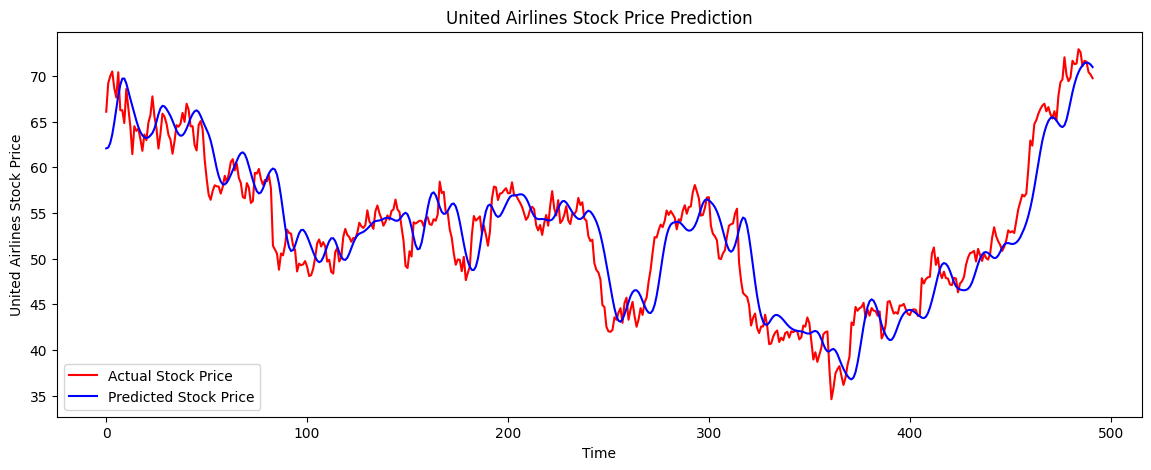

In [49]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('United Airlines Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('United Airlines Stock Price')
plt.legend()
plt.show()